# Characterize the population of remnant black holes

In [2]:
import numpy as np
import numpy.lib.recfunctions
import h5py
import json
%matplotlib inline
from matplotlib import pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from scipy.interpolate import interp1d
import matplotlib 
matplotlib.rcParams['text.usetex'] = True
%config InlineBackend.figure_format='retina'
from scipy.stats import gaussian_kde
import gwpopulation as gwp
import surfinBH
from multiprocessing import Pool
import matplotlib.transforms as mtransforms
import collections.abc
import copy
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

### Integrate the rate over time. 
For field binaries, we'll assume the rate follows the cosmic star formation rate, but with some fiducial delay time distribution.  We'll use the star formation rate from [Madau and Fragos](https://arxiv.org/pdf/1606.07887.pdf):
$$\psi(z) = 0.01 \frac{(1+z)^{2.6}}{1+[(1+z)/3.2]^{6.2}} \textrm{M}_\odot \textrm{yr}^{-1}\textrm{Mpc}^{-3}$$
For the delay time distribution, we'll assume:
$$p(t_d) \propto t_d^{-1}\ \textrm{if}\ t_d>10\ \textrm{Myr, else}\ 0$$
The merger rate over cosmic time is:
$$R(t) = A \int_0^{t} p(t-t')\psi(t') dt'$$
And we know that $R(t_h) = R_0$ where $R_0$ is the present-day rate inferred by the LVC, so:
$$A = \frac{R_0}{\int_0^{t_h} p(t-t')\psi(t') dt'}$$
The current number density of remnants is:
$$n = \int_0^{t_h} R(t) dt = R_0\frac{\int_0^{t_h} \int_0^{t} p(t-t')\psi(t') dt'}{\int_0^{t_h} p(t-t')\psi(t') dt'}$$

Now for globular clusters, we'll use the merger rate vs redshift from [Rodriguez and Loeb](https://iopscience.iop.org/article/10.3847/2041-8213/aae377) but normalize it so that the z=0 rate matches that from the LVC inferences.  The black curve in the top panel of their Figure 1 could be approximated by a Gaussian with a mean of z=2.67 and a sigma ~ 1.5. 

In [7]:
class RateCalculator(FlatLambdaCDM):
    def __init__(self,H0=70., Om0=0.3,alpha=1,td_min=1e7):
        self.dist_unit = u.megaparsec
        self.time_unit = u.year
        self.alpha= alpha
        self.td_min = td_min #minimum delay time
        super().__init__(H0,Om0)
        self.z_min,self.z_max = 0.0001,15
        #self.zgrid = np.linspace(self.z_min,self.z_max,2000)
        self.zgrid = np.logspace(np.log10(self.z_min),np.log10(self.z_max),5000)
        self.t_of_zgrid = self.hubble_time.to_value(self.time_unit) - self.lookback_time(self.zgrid).to_value(self.time_unit)
        self.t_min = np.amin(self.t_of_zgrid) # age of universe at z_max
        self.t_of_z = interp1d(self.zgrid,self.t_of_zgrid)
        self.z_of_t = interp1d(self.t_of_zgrid,self.zgrid)
        self.R_norm = self.R_of_t(self.hubble_time.to_value(self.time_unit))
        
        
    def sfr_of_t(self,t):
        """Return star formation rate in units of solar masses per year per cubic Mpc"""
        z = self.z_of_t(t) 
        return self.sfr_of_z(z)
        
    def sfr_of_z(self,z):
        return 0.01*(1.+z)**2.6 / (1.+((1.+z)/3.2)**6.2)

    def p_delay_time(self,t):
        """un-normalized probability of a given delay time for a 
        delay time distribution t_d^-alpha where t_d > t_min, else 0
        """
        return np.array([ti**(-self.alpha) if ti>self.td_min else 0 for ti in t])
    
    def R_of_t(self,t):
        sel = self.t_of_zgrid <= t
        # negative sign below to deal with t_of_zgrid going from high to low
        return -np.trapz(self.sfr_of_t(self.t_of_zgrid[sel])*self.p_delay_time(t-self.t_of_zgrid[sel]),self.t_of_zgrid[sel])
    
    def number_density(self,t=None,present_rate=1e-7):
        if t is None:
            t = self.hubble_time.to_value(self.time_unit)
        integrand_vals = np.array(list(map(self.R_of_t,self.t_of_zgrid)))
        sel = self.t_of_zgrid <= t
        return -present_rate*np.trapz(integrand_vals[sel],self.t_of_zgrid[sel])/self.R_norm
    
    def R_of_z_GC(self,z,present_rate=1e-7,mu=2.67,sig=1.5):
        return present_rate*np.exp(mu**2/(2*(sig**2)))*np.exp(-((z-mu)**2)/((2*sig**2)))
    
    def number_density_GC(self,present_rate=1e-7,mu=2.67,sig=1.5):
        # negative sign below to deal with t_of_zgrid going from high to low
        return -np.trapz(self.R_of_z_GC(self.zgrid,present_rate=present_rate,mu=mu,sig=sig),self.t_of_zgrid)
        

In [8]:
rate_calc = RateCalculator()

the current number density of remnant black holes is 2783.8063759934735 per cubic megaparsec for field and 2974.368804955589 for globular clusters


Text(0, 0.5, 'rate')

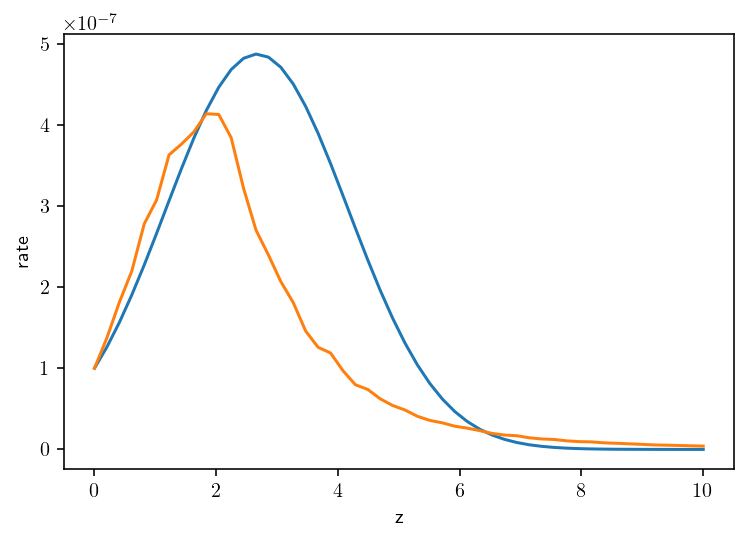

In [9]:
number_density = rate_calc.number_density()
number_density_GC = rate_calc.number_density_GC()
print(f'the current number density of remnant black holes is {number_density} per cubic megaparsec for field and {number_density_GC} for globular clusters')
test_zs = np.linspace(0.001,10)
plt.plot(test_zs,rate_calc.R_of_z_GC(test_zs))
plt.plot(test_zs,[1e-7*rate_calc.R_of_t(rate_calc.t_of_z(test_z))/rate_calc.R_norm for test_z in test_zs])
plt.xlabel('z')
plt.ylabel('rate')

## Incorporate population hyperposterior samples
Here we're going to use the latest and greatest from O3a results.  The power-law + peak model had the highest BF in the O3a populations paper, so that's the one we'll use for this analysis.  The tricky part is pulling individual merger samples for each hyperparameter sample.  We'll do that using a mix of reverse CDF sampling and rejection sampling

In [10]:
# Get population hyperparameter samples for the power law + peak samples
# Load Power Law + Peak samples
with open("Population_Samples/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)
    priors = jf['priors']
    posterior_samples = jf['posterior']['content']
    
# add in the mean and variance of the spin mag beta distribution converted to alpha and beta:
mu = np.array(posterior_samples['mu_chi'])
sigma_sqrd = np.array(posterior_samples['sigma_chi']) # this is mislabeled in the file as sigma instead of variance
posterior_samples['alpha_chi'] = ((1. - mu) / sigma_sqrd - 1. /mu ) * (mu ** 2.)
posterior_samples['beta_chi'] = posterior_samples['alpha_chi']*(1.-mu)/mu

In [11]:
# create the population hyperparameter samples
n_prior_samples = 500
prior_samp_dict = {}
for key in list(priors.keys()):
    try:
        print(key,priors[key]['__name__'],priors[key]['kwargs'])
        if priors[key]['__name__']=='Uniform':
            prior_samp_dict[key] = np.random.uniform(priors[key]['kwargs']['minimum'],priors[key]['kwargs']['maximum'],size=n_prior_samples)
    except:
        pass
mu = np.array(prior_samp_dict['mu_chi'])
sigma_sqrd = np.array(prior_samp_dict['sigma_chi']) # this is mislabeled in the file as sigma instead of variance
prior_samp_dict['alpha_chi'] = ((1. - mu) / sigma_sqrd - 1. /mu ) * (mu ** 2.)
prior_samp_dict['beta_chi'] = prior_samp_dict['alpha_chi']*(1.-mu)/mu


# need to obey constraints on the alpha_chi and beta_chi even though prior is flat in variance and mean
# iteratively replace alpha_chi and beta_chi values that are outside the constraints
sel = (prior_samp_dict['alpha_chi']<1) | (prior_samp_dict['beta_chi']<1) | (prior_samp_dict['alpha_chi']>100000) | (prior_samp_dict['beta_chi']>100000)
count = 0
while np.any(sel): 
    nbad = np.sum(sel)
    for key in ['mu_chi','sigma_chi']:
        prior_samp_dict[key][sel] = np.random.uniform(priors[key]['kwargs']['minimum'],priors[key]['kwargs']['maximum'],size=nbad)
    mu = np.array(prior_samp_dict['mu_chi'])
    sigma_sqrd = np.array(prior_samp_dict['sigma_chi']) # this is mislabeled in the file as sigma instead of variance
    prior_samp_dict['alpha_chi'] = ((1. - mu) / sigma_sqrd - 1. /mu ) * (mu ** 2.)
    prior_samp_dict['beta_chi'] = prior_samp_dict['alpha_chi']*(1.-mu)/mu
    sel = (prior_samp_dict['alpha_chi']<1) | (prior_samp_dict['beta_chi']<1) | (prior_samp_dict['alpha_chi']>100000) | (prior_samp_dict['beta_chi']>100000)
    count += 1
    if count > 100:
        print('hit limit!')
        break

alpha Uniform {'minimum': -4, 'maximum': 12, 'name': 'alpha', 'latex_label': '$\\alpha$', 'unit': None, 'boundary': 'reflective'}
beta Uniform {'minimum': -4, 'maximum': 12, 'name': 'beta', 'latex_label': '$\\beta_{q}$', 'unit': None, 'boundary': None}
mmax Uniform {'minimum': 30, 'maximum': 100, 'name': 'mmax', 'latex_label': '$m_{\\max}$', 'unit': None, 'boundary': None}
mmin Uniform {'minimum': 2, 'maximum': 10, 'name': 'mmin', 'latex_label': '$m_{\\min}$', 'unit': None, 'boundary': None}
lam Uniform {'minimum': 0, 'maximum': 1, 'name': 'lambda', 'latex_label': '$\\lambda_{m}$', 'unit': None, 'boundary': None}
mpp Uniform {'minimum': 20, 'maximum': 50, 'name': 'mpp', 'latex_label': '$\\mu_{m}$', 'unit': None, 'boundary': None}
sigpp Uniform {'minimum': 0.4, 'maximum': 10, 'name': 'sigpp', 'latex_label': '$\\sigma_{m}$', 'unit': None, 'boundary': None}
delta_m Uniform {'minimum': 0, 'maximum': 10, 'name': 'delta_m', 'latex_label': '$\\delta_{m}$', 'unit': None, 'boundary': None}
amax

Set up the grids which will be sampled based on population weighting

In [12]:
mass_dist_params = ['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m']
spinmag_dist_params = ['alpha_chi', 'beta_chi']
spintilt_params = ['xi_spin', 'sigma_spin']
hyp_name_dict = {'mass':mass_dist_params,
               'spinmag':spinmag_dist_params,
               'spintilt':spintilt_params
              }

masspop = gwp.models.mass.SinglePeakSmoothedMassDistribution()
spinmagpop = gwp.models.spin.iid_spin_magnitude_beta #(dataset, xi_spin, sigma_spin, amax, alpha_chi, beta_chi)
spintiltpop = gwp.models.spin.iid_spin_orientation_gaussian_isotropic
pops = {'mass':masspop,'spinmag':spinmagpop,'spintilt':spintiltpop}

# set up mass grid 
m1s_grid = np.linspace(3,100,400)
qs_grid = np.linspace(0.01,1,100)
M1s,Qs = np.meshgrid(m1s_grid,qs_grid)
mass_pts = np.array(list(zip(M1s.flatten(),Qs.flatten())),dtype=[('mass_1',float),('mass_ratio',float)])

# set up spin mag grid
as_grid = np.linspace(0,1,100)
A1s,A2s = np.meshgrid(as_grid,as_grid)
as_pts = np.array(list(zip(A1s.flatten(),A2s.flatten())),dtype=[('a_1',float),('a_2',float)])

# set up spin tilt grid
costilts_grid = np.linspace(-1,1,100)
Ctilts1,Ctilts2 = np.meshgrid(costilts_grid,costilts_grid)
costilts_pts = np.array(list(zip(Ctilts1.flatten(),Ctilts2.flatten())),dtype=[('cos_tilt_1',float),('cos_tilt_2',float)])

grids = {'mass':mass_pts,'spinmag':as_pts,'spintilt':costilts_pts}

def get_event_samples(hypersample,n_samples=1000):
    sample_arr = []
    for hypname in pops.keys():
        hyp_dict = {param:hypersample[param] for param in hyp_name_dict[hypname]}
        ps = pops[hypname](grids[hypname],**hyp_dict)
        samples = np.random.choice(grids[hypname],size=n_samples,replace=True,p=ps/np.sum(ps))
        sample_arr.append(samples)
    return np.lib.recfunctions.merge_arrays(sample_arr,flatten=True,usemask=False)
    
def mag_tilt_to_components(a,cos_tilt):
    phase = np.random.uniform(2*np.pi)
    sin_tilt = np.sqrt(1.-cos_tilt**2)
    return [
        a*sin_tilt*np.cos(phase), #x
        a*sin_tilt*np.sin(phase), #y
        a*cos_tilt #z
    ]    

def get_weights(hypersample,event_samples):
    ps_arr = []
    for hypname in pops.keys():
        hyp_dict = {param:hypersample[param] for param in hyp_name_dict[hypname]}
        ps_arr.append(pops[hypname](event_samples,**hyp_dict))
    return np.multiply.reduce(ps_arr)

Get mass and spin samples from the maxL population

In [23]:
n_event_samples = int(2**14)
max_L_idx = np.argmax(posterior_samples['log_likelihood'])
fid_pop_samples = get_event_samples({key:value[max_L_idx] for key,value in posterior_samples.items()},
                                    n_samples=n_event_samples)
np.save('fid_pop_samples.npy',fid_pop_samples)

/Users/Zoheyr/opt/anaconda3/envs/remnant_env/lib/python3.7/site-packages/gwpopulation/models/mass.py:434: RuntimeWarning: overflow encountered in exp
  window[smoothing_region] = 1 / (xp.exp(exponent) + 1)
/Users/Zoheyr/opt/anaconda3/envs/remnant_env/lib/python3.7/site-packages/gwpopulation/utils.py:11: RuntimeWarning: divide by zero encountered in log
  ln_beta = (alpha - 1) * xp.log(xx) + (beta - 1) * xp.log(scale - xx)


Now use SurfinBH to get the final masses and spins

In [62]:
fit7dq4 = surfinBH.LoadFits('NRSur7dq4Remnant')
fit3dq8 = surfinBH.LoadFits('NRSur3dq8Remnant')

G = 6.67e-11 # Units: m^3 / (kg s^2)
c = 3e8 # Units: m/s
Msol = 1.989e30 # Units: kg
fref = 20 # Units: 1/s

# def calc_final_state(samples,seed=1234,dither=False):
#     np.random.seed(seed)
#     q = 1./samples['mass_ratio'] # use q>=1 definition
#     if q <= 6:
#         chi_1 = mag_tilt_to_components(samples['a_1'],samples['cos_tilt_1'])
#         chi_2 = mag_tilt_to_components(samples['a_2'],samples['cos_tilt_2'])
#         mtot = Msol*samples['mass_1']*(1.+1./q) # Units: kg
#         omega0 = 2.*np.pi*(fref/2.)*G*mtot/(c**3)
#         mf, chif, vf, mferr, chiferr, vferr = fit7dq4.all(q, chi_1, chi_2,omega0=omega0,allow_extrap=True,PN_dt=5)
#         mf_samp,chif_samp,vf_samp = np.random.normal(mf,mferr),np.random.normal(chif,chiferr),np.random.normal(vf,vferr)
#         chif_samp,vf_samp = np.linalg.norm(chif_samp), np.linalg.norm(vf_samp)
#         while ((mf_samp<0) | (mf_samp>1) | (chif_samp <0) | (chif_samp >1) | (vf_samp<0)):
#             mf_samp,chif_samp,vf_samp = np.random.normal(mf,mferr),np.random.normal(chif,chiferr),np.random.normal(vf,vferr)
#             chif_samp,vf_samp = np.linalg.norm(chif_samp), np.linalg.norm(vf_samp)          
#         return mf_samp*samples['mass_1']*(1.+1./q),chif_samp,vf_samp
#     else:
#         chi_1 = [0,0,samples['a_1']*samples['cos_tilt_1']]
#         chi_2 = [0,0,samples['a_2']*samples['cos_tilt_2']]
#         mf, chif, vf, mferr, chiferr, vferr = fit3dq8.all(q, chi_1, chi_2,allow_extrap=True)
#         mf_samp,chif_samp,vf_samp = np.random.normal(mf,mferr),np.random.normal(chif,chiferr),np.random.normal(vf,vferr)
#         chif_samp,vf_samp = np.linalg.norm(chif_samp), np.linalg.norm(vf_samp)
#         while ((mf_samp<0) | (mf_samp>1) | (chif_samp <0) | (chif_samp >1) | (vf_samp<0)):
#             mf_samp,chif_samp,vf_samp = np.random.normal(mf,mferr),np.random.normal(chif,chiferr),np.random.normal(vf,vferr)
#             chif_samp,vf_samp = np.linalg.norm(chif_samp), np.linalg.norm(vf_samp) 
#         return mf_samp*samples['mass_1']*(1.+1./q),chif_samp,vf_samp

def calc_final_state(samples,seed=1234,dither=True):
    np.random.seed(seed)
    q = 1./samples['mass_ratio'] # use q>=1 definition
    if q <= 6:
        chi_1 = mag_tilt_to_components(samples['a_1'],samples['cos_tilt_1'])
        chi_2 = mag_tilt_to_components(samples['a_2'],samples['cos_tilt_2'])
        mtot = Msol*samples['mass_1']*(1.+1./q) # Units: kg
        omega0 = 2.*np.pi*(fref/2.)*G*mtot/(c**3)
        mf, chif, vf, mferr, chiferr, vferr = fit7dq4.all(q, chi_1, chi_2,omega0=omega0,allow_extrap=True,PN_dt=5)
    else:
        chi_1 = [0,0,samples['a_1']*samples['cos_tilt_1']]
        chi_2 = [0,0,samples['a_2']*samples['cos_tilt_2']]
        mf, chif, vf, mferr, chiferr, vferr = fit3dq8.all(q, chi_1, chi_2,allow_extrap=True)
    if dither:
        mf_samp,chif_samp,vf_samp = np.random.normal(mf,mferr),np.random.normal(chif,chiferr),np.random.normal(vf,vferr)
        chif_samp,vf_samp = np.linalg.norm(chif_samp), np.linalg.norm(vf_samp)
        while ((mf_samp<0) | (mf_samp>1) | (chif_samp <0) | (chif_samp >1) | (vf_samp<0)):
            mf_samp,chif_samp,vf_samp = np.random.normal(mf,mferr),np.random.normal(chif,chiferr),np.random.normal(vf,vferr)
            chif_samp,vf_samp = np.linalg.norm(chif_samp), np.linalg.norm(vf_samp) 
    else:
        mf_samp,chif_samp,vf_samp = mf, np.linalg.norm(chif), np.linalg.norm(vf)
    return mf_samp*samples['mass_1']*(1.+1./q),chif_samp,vf_samp



Loaded NRSur7dq4Remnant fit.
Loaded NRSur3dq8Remnant fit.


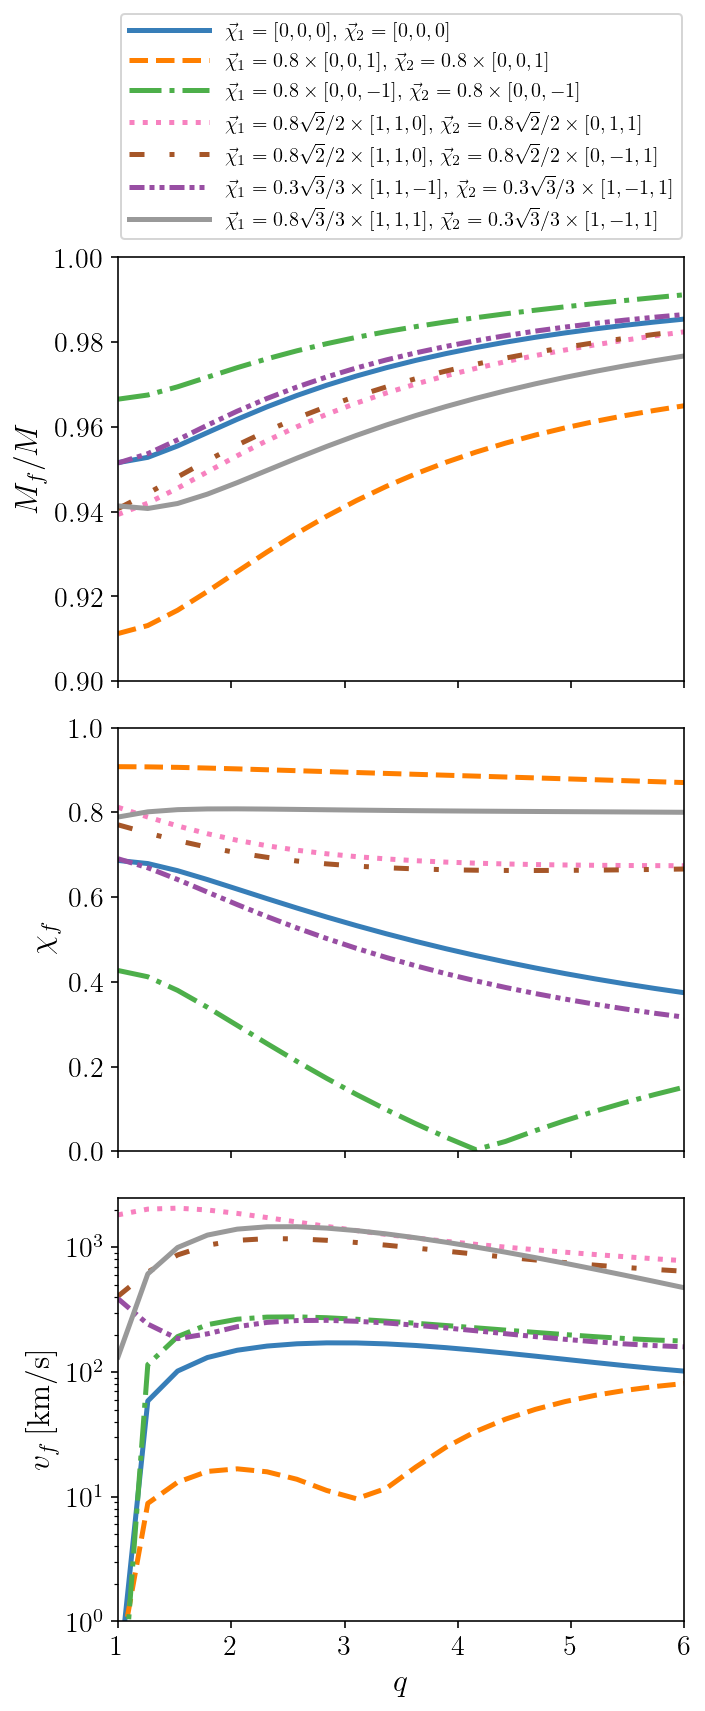

In [68]:
myqs = np.linspace(1,6,20)


spin_configs = [
    ([0,0,0],[0,0,0]),
    (0.8*np.array([0,0,1]),0.8*np.array([0,0,1])),
    (-0.8*np.array([0,0,1]),-0.8*np.array([0,0,1])),
    ([0.8*np.sqrt(2)/2.,0.8*np.sqrt(2)/2.,0],[0,0.8*np.sqrt(2)/2.,0.8*np.sqrt(2)/2.]),
    ([0.8*np.sqrt(2)/2.,0.8*np.sqrt(2)/2.,0],[0,-0.8*np.sqrt(2)/2.,0.8*np.sqrt(2)/2.]),
    #([0.3*np.sqrt(2)/2.,0.3*np.sqrt(2)/2.,0],[0,0.3*np.sqrt(2)/2.,0.3*np.sqrt(2)/2.]),
    #([0.3*np.sqrt(2)/2.,0.3*np.sqrt(2)/2.,0],[0,-0.3*np.sqrt(2)/2.,0.3*np.sqrt(2)/2.]),
    ([0.3*np.sqrt(3)/3,0.3*np.sqrt(3)/3,-0.3*np.sqrt(3)/3],[0.3*np.sqrt(3)/3,-0.3*np.sqrt(3)/3,0.3*np.sqrt(3)/3]),
    ([0.8*np.sqrt(3)/3,0.8*np.sqrt(3)/3,0.8*np.sqrt(3)/3],[0.3*np.sqrt(3)/3,-0.3*np.sqrt(3)/3,0.3*np.sqrt(3)/3])  
]

spin_names = [
    r'$\vec{\chi}_1=[0,0,0],\, \vec{\chi}_2=[0,0,0]$',
    r'$\vec{\chi}_1=0.8\times[0,0,1],\, \vec{\chi}_2=0.8\times[0,0,1]$',
    r'$\vec{\chi}_1=0.8\times[0,0,-1],\, \vec{\chi}_2=0.8\times[0,0,-1]$',
    r'$\vec{\chi}_1=0.8\sqrt{2}/2 \times[1,1,0],\, \vec{\chi}_2=0.8\sqrt{2}/2\times[0,1,1]$',
    r'$\vec{\chi}_1=0.8\sqrt{2}/2\times[1,1,0],\, \vec{\chi}_2=0.8\sqrt{2}/2\times[0,-1,1]$',
    r'$\vec{\chi}_1=0.3\sqrt{3}/3\times[1,1,-1],\, \vec{\chi}_2=0.3\sqrt{3}/3\times[1,-1,1]$',
    r'$\vec{\chi}_1=0.8\sqrt{3}/3\times[1,1,1],\, \vec{\chi}_2=0.3\sqrt{3}/3\times[1,-1,1]$',
]

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

lss = ['-','--','-.',':',(0, (3, 5, 1, 5)),(0, (3, 1, 1, 1, 1, 1))]

fig,axes = plt.subplots(3,sharex=True,figsize=(5,12))
axes = axes.flatten()

for i,config in enumerate(spin_configs):
    myvs = []
    myfMs = []
    mychis = []
    for q in myqs:
        testfM,testchi,testvf,_,_,_ = fit7dq4.all(q,config[0],config[1],allow_extrap=True)
        myvs.append(np.linalg.norm(testvf))
        myfMs.append(testfM)
        mychis.append(np.linalg.norm(testchi))
    axes[0].plot(myqs,np.array(myfMs),color=CB_color_cycle[i],lw=2.5,ls=lss[i%len(lss)],label=spin_names[i])
    axes[1].plot(myqs,np.array(mychis),color=CB_color_cycle[i],lw=2.5,ls=lss[i%len(lss)])
    axes[2].plot(myqs,3e5*np.array(myvs),color=CB_color_cycle[i],lw=2.5,ls=lss[i%len(lss)])

ylims = [(0.9,1),(0,1),(1,2500)]
for i,label in enumerate([r'$M_f/M$',r'$\chi_f$',r'$v_f\, [\mathrm{km/s}]$']):
    axes[i].set_ylabel(label,fontsize=16)
    axes[i].set_ylim(ylims[i])
    axes[i].tick_params(labelsize=14)
axes[0].set_xlim([1,6])
axes[2].set_xlabel('$q$',fontsize=16)
axes[2].set_yscale('log')
axes[0].legend(bbox_to_anchor=(0.5,1.02),loc='lower center',handlelength=4)
fig.tight_layout()
fig.savefig('example_remnant_params.pdf')
fig.savefig('example_remnant_params.png',dpi=300)

In [10]:
setup = """import surfinBH
fit = surfinBH.LoadFits('NRSur7dq4Remnant')
q = 3.2
chiA = [0, 0, 0.3]
chiB = [0, 0, 0.1]
omega0 = 7e-3
import warnings
import h5py
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=h5py.h5py_warnings.H5pyDeprecationWarning) 
"""
import timeit
timeit.timeit("fit.all(5, chiA, chiB,omega0=omega0)",setup=setup,number=10)

Loaded NRSur7dq4Remnant fit.
Loaded NRSur7dq4 model


11.11311539899998

In [63]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=h5py.h5py_warnings.H5pyDeprecationWarning)
pool = Pool(4)
final_params = np.array(pool.map(calc_final_state,fid_pop_samples))
#final_params = np.array(list(map(calc_final_state,fid_pop_samples)))
np.save('final_params.npy',final_params)

Loaded NRSur7dq4 modelLoaded NRSur7dq4 model

Loaded NRSur7dq4 model
Loaded NRSur7dq4 model


In [73]:
final_params = np.load('final_params.npy')
fid_pop_samples = np.load('fid_pop_samples.npy')

# Get the weights
First for the hyperposterior samples

In [76]:
def weighted_percentile(a,w,q):
    """
    a: array of samples
    w: weights of samples
    q: percentiles
    """
    w=w/np.sum(w)
    sorta = np.array([s for s,_ in sorted(zip(a,w))])
    sortw = np.array([wt for _,wt in sorted(zip(a,w))])
    if isinstance(q,collections.abc.Iterable):
        return np.array([sorta[np.cumsum(sortw)>(qi/100.)][0] for qi in q])
    else:
        return sorta[np.cumsum(sortw)>(q/100.)][0]

n_grid_pts = 100 
mass_plot_grid = np.linspace(6,200,n_grid_pts)
chif_plot_grid = np.linspace(0,1,n_grid_pts)
vf_plot_grid = np.linspace(0,4,n_grid_pts)
#scales = [1.,1.,3e5]
transforms = [lambda x:x, lambda x:x, lambda x:(np.log10(3e5*x))]
plot_grids = [mass_plot_grid,chif_plot_grid,vf_plot_grid]
xlabels = ['M_f','\chi_f','v_f']

base_rate = rate_calc.number_density(present_rate=1.)
base_rate_GC = rate_calc.number_density_GC(present_rate=1.)

fid_weights = get_weights({key:value[max_L_idx] for key,value in posterior_samples.items()},fid_pop_samples)



n_hyper_lines = 2000 
n_params = len(xlabels)
percentiles = [1,50,99]
pctl_array = np.empty((len(percentiles),n_hyper_lines,n_params))
lines = np.empty([n_grid_pts,n_hyper_lines,n_params])
rates = [] # collect field rates
rates_GC = [] # collect GC rates
hyp_idx = []
wts_arr = []
q_frac_6 = []

# set up stuff to get fractions of things that could stay in clusters
clusters_cats = np.array(['YSC','GC','NSC'])
n_cluster_cats = len(clusters_cats)
cluster_escape_vels = np.power(10.,4.*np.array([0.25,1.7/4,2.4/4])) # km per sec
escape_vel_sels = [3e5*final_params[:,2] < vel for vel in cluster_escape_vels]
vf_cluster_fracs = np.empty([n_hyper_lines,n_cluster_cats]) # hold fractions of events that can stay in clusters
vf_cluster_lines = np.empty([n_grid_pts,n_hyper_lines,n_params-1,n_cluster_cats]) # hold number density lines

for i,k in enumerate(np.random.choice(len(posterior_samples['alpha']),size=n_hyper_lines,replace=False)):
    
    # get weights
    hyp_idx.append(k)
    wts = get_weights({key:value[k] for key,value in posterior_samples.items()},fid_pop_samples)/fid_weights ;
    wts[np.isnan(wts) | np.isinf(wts)] = 0.
    
    wts = wts/np.sum(wts)
    print(wts)
    wts_arr.append(wts)
    
    # check fraction of events with q>6
    pop_samps = np.random.choice(fid_pop_samples,size=1000,p=wts)
    q_frac_6.append(np.sum(pop_samps['mass_ratio']<(1./6))/len(pop_samps))
    
    rate = base_rate*(10.**posterior_samples['log_10_rate'][k])*1e-9 #1e-9 to convert to Mpc^3
    rate_GC = base_rate_GC*(10.**posterior_samples['log_10_rate'][k])*1e-9
    rates.append(rate)
    rates_GC.append(rate_GC)
    
    # get fractions of pop retained for the cluster escape velocities
    for j in range(n_params):
        pctl_array[:,i,j] = weighted_percentile(transforms[j](final_params[:,j]),wts,q=percentiles)
        lines[:,i,j] = rate*gaussian_kde(transforms[j](final_params[:,j]),weights=wts)(plot_grids[j])
        for si,sel in enumerate(escape_vel_sels):
            frac_in_cluster = np.sum(wts[sel])/np.sum(wts)
            vf_cluster_fracs[i,si] = frac_in_cluster
            if j < 2:
                if np.sum(sel)==0:
                    continue
                vf_cluster_lines[:,i,j,si] = rate*frac_in_cluster*gaussian_kde(transforms[j](final_params[:,j][sel]),weights=wts[sel]/np.sum(wts[sel]))(plot_grids[j])

hyp_idx = np.array(hyp_idx)
wts_arr = np.array(wts_arr)
print(f'an average fraction of {np.mean(q_frac_6)} events have q>6')        

# calculate rates and CIs
rates = np.array(rates)
m_rate,l_rate,u_rate = np.median(rates),np.percentile(rates,5),np.percentile(rates,95)
rates_mwev = rates*10. # 0.1 galaxy per cubic megaparsec -> 10 cubic megaparsecs per galaxy
m_rate_mwev,l_rate_mwev,u_rate_mwev = np.median(rates_mwev),np.percentile(rates_mwev,5),np.percentile(rates_mwev,95)

rates_GC = np.array(rates_GC)
m_rate_GC,l_rate_GC,u_rate_GC = np.median(rates_GC),np.percentile(rates_GC,5),np.percentile(rates_GC,95)
rates_mwev_GC = rates_GC*10. # 0.1 galaxy per cubic megaparsec -> 10 cubic megaparsecs per galaxy
m_rate_mwev_GC,l_rate_mwev_GC,u_rate_mwev_GC = np.median(rates_mwev_GC),np.percentile(rates_mwev_GC,5),np.percentile(rates_mwev_GC,95)

/Users/Zoheyr/opt/anaconda3/envs/remnant_env/lib/python3.7/site-packages/gwpopulation/models/mass.py:434: RuntimeWarning: overflow encountered in exp
  window[smoothing_region] = 1 / (xp.exp(exponent) + 1)


[8.40767179e-05 5.70346238e-07 1.97063989e-06 ... 4.05576262e-05
 2.12484796e-07 1.04056262e-06]


/Users/Zoheyr/opt/anaconda3/envs/remnant_env/lib/python3.7/site-packages/gwpopulation/models/mass.py:370: RuntimeWarning: invalid value encountered in true_divide
  p_q /= self.norm_p_q(beta=beta, mmin=mmin, delta_m=delta_m)


[3.17313424e-05 3.19330405e-07 0.00000000e+00 ... 3.70739374e-05
 6.73324301e-07 2.04329980e-06]
[5.71581800e-05 1.49072401e-06 0.00000000e+00 ... 7.35828101e-05
 9.29291297e-07 2.33072512e-06]
[1.18199823e-04 1.44175902e-06 0.00000000e+00 ... 4.99325372e-05
 3.68413030e-07 1.87882426e-06]
[4.49312816e-05 1.30734842e-07 1.62206301e-04 ... 1.27800431e-05
 3.09243722e-07 4.39556035e-07]
[3.48131427e-05 3.40814824e-05 2.93527834e-05 ... 4.97285612e-05
 6.03235145e-05 1.38243837e-05]
[3.16409709e-05 4.93677011e-07 0.00000000e+00 ... 4.20514929e-05
 9.32936526e-08 1.00839959e-06]
[1.42025066e-04 2.98840204e-06 0.00000000e+00 ... 3.49500219e-05
 3.00985982e-07 1.31646623e-06]
[3.98446295e-05 2.03620263e-07 4.10274250e-05 ... 2.86242705e-05
 2.10581475e-07 1.26979998e-06]
[2.01764109e-05 2.10086087e-06 0.00000000e+00 ... 3.53150835e-05
 1.25007799e-05 1.78500239e-05]
[1.44340623e-05 8.60535680e-07 0.00000000e+00 ... 3.47947123e-05
 5.94089100e-07 7.38623476e-06]
[4.89001547e-05 1.02124898e-05

[8.68554331e-05 1.13655368e-06 0.00000000e+00 ... 1.11400211e-04
 5.20602108e-08 1.33006201e-06]
[6.64596656e-05 2.57087413e-07 0.00000000e+00 ... 6.26658190e-05
 9.56947756e-08 9.40066998e-07]
[3.01491752e-05 1.13282474e-06 0.00000000e+00 ... 4.55367381e-06
 4.84093886e-06 3.79799774e-07]
[6.60929392e-05 2.77221277e-06 0.00000000e+00 ... 4.11925763e-05
 1.21662413e-06 2.22706365e-06]
[7.15072186e-05 2.35369920e-06 3.41121978e-06 ... 1.35137141e-04
 2.24880373e-07 2.74853175e-06]
[7.80458594e-05 3.85800310e-07 4.98069397e-05 ... 7.69680913e-05
 2.59857340e-08 4.08331416e-07]
[5.21362024e-05 5.24706752e-06 1.43334271e-16 ... 1.12806652e-04
 4.06294457e-06 1.69449363e-05]
[5.74457279e-05 1.01775992e-07 0.00000000e+00 ... 9.13710070e-05
 1.95496045e-08 6.56707126e-07]
[2.87850187e-05 2.73801352e-07 0.00000000e+00 ... 3.39805393e-05
 1.16852423e-06 4.27164050e-06]
[8.28845184e-05 1.24085037e-06 0.00000000e+00 ... 3.98227172e-05
 5.74581629e-07 1.17274393e-06]
[7.59138648e-05 9.24307613e-07

[4.27081973e-05 2.20015651e-06 0.00000000e+00 ... 5.18112566e-05
 1.04459465e-06 3.60102204e-06]
[3.90135519e-05 7.38902465e-06 1.25039713e-18 ... 6.21574050e-05
 3.55682196e-06 1.29265548e-05]
[1.09720513e-04 9.85786837e-07 5.56956498e-25 ... 1.94593561e-04
 3.53513083e-08 1.29549351e-06]
[6.05925436e-05 1.18763203e-06 0.00000000e+00 ... 3.59240892e-05
 9.47898012e-07 4.29385185e-06]
[6.63892538e-05 8.87944169e-07 0.00000000e+00 ... 4.36032184e-05
 4.67278439e-07 1.11888984e-06]
[4.45346347e-05 4.06227231e-07 6.16790003e-05 ... 9.50019167e-05
 2.13735836e-07 3.85690646e-06]
[4.69709136e-05 9.47318232e-07 2.91657968e-08 ... 8.59078791e-05
 2.12206982e-07 2.70341530e-06]
[9.85287066e-06 1.19012804e-07 8.08945352e-06 ... 1.90636397e-05
 8.09304962e-08 8.85715357e-07]
[1.33202238e-05 1.16761522e-06 0.00000000e+00 ... 6.93811280e-06
 3.27977601e-06 4.72273533e-06]
[5.46675408e-05 1.44689888e-07 8.32520994e-05 ... 9.91700401e-06
 3.36339784e-07 1.03824498e-06]
[6.88281209e-05 1.94525463e-06

[8.52895560e-05 1.37906441e-06 0.00000000e+00 ... 2.21022551e-05
 1.41645544e-06 1.25682157e-06]
[1.14816057e-04 1.40717025e-07 1.28592965e-20 ... 3.01759464e-05
 6.16699458e-08 4.74834970e-07]
[5.53348413e-05 2.14642336e-09 0.00000000e+00 ... 6.05840292e-05
 2.54732614e-10 4.20695842e-08]
[5.55815274e-05 1.21924661e-06 0.00000000e+00 ... 2.98837370e-05
 2.58174188e-06 2.22862122e-06]
[8.17811509e-05 5.60086211e-07 0.00000000e+00 ... 3.47325171e-05
 2.95544123e-07 5.50206600e-07]
[1.72857040e-04 3.22338139e-06 0.00000000e+00 ... 3.14190330e-06
 5.81158387e-06 1.55891300e-06]
[9.64308939e-05 5.03757326e-07 0.00000000e+00 ... 4.32553460e-05
 4.53560979e-08 1.94575561e-07]
[1.16452636e-04 8.23412840e-07 0.00000000e+00 ... 1.62535760e-06
 1.59232072e-06 1.74900109e-07]
[4.95850918e-05 6.43806635e-07 5.73565258e-05 ... 5.84198187e-05
 1.79083484e-07 1.24762306e-06]
[1.87509093e-05 3.69787933e-07 4.22788568e-05 ... 4.24344994e-05
 1.21386971e-07 1.56497519e-06]
[7.34957823e-05 1.97080870e-06

[9.21217652e-05 7.95283420e-08 0.00000000e+00 ... 3.11036053e-05
 2.93172912e-08 2.64954832e-07]
[3.83516792e-05 3.02174207e-07 6.07641830e-05 ... 6.68255800e-05
 1.97675498e-07 6.96218140e-07]
[7.55662929e-06 7.53170084e-08 0.00000000e+00 ... 4.08995795e-06
 9.19382081e-08 5.12184273e-07]
[1.13060525e-04 4.35298041e-06 3.20575239e-08 ... 3.49660062e-05
 2.68039381e-06 1.91777645e-06]
[2.60734776e-05 5.74290680e-06 1.15688449e-86 ... 4.64346513e-05
 1.01532549e-05 1.47086330e-05]
[7.25090850e-05 2.60611956e-07 1.69419215e-04 ... 6.10814565e-05
 1.09872197e-07 7.56381006e-07]
[2.71130855e-05 2.76249549e-06 4.10037891e-04 ... 8.07970617e-06
 1.55548604e-06 1.72631337e-06]
[9.16437698e-05 2.61180701e-06 0.00000000e+00 ... 2.79638333e-05
 8.52287081e-07 1.52996523e-06]
[1.02266687e-04 8.00746976e-07 5.02000707e-06 ... 7.26530346e-05
 8.63552845e-08 3.02602718e-07]
[4.67047278e-05 5.27621387e-07 0.00000000e+00 ... 5.20038681e-05
 4.47474204e-07 2.29678897e-06]
[5.35409448e-05 1.07187400e-05

[7.03084609e-05 1.08723453e-06 1.89126117e-06 ... 9.12538212e-05
 1.02612872e-07 1.74902446e-06]
[4.70201155e-05 7.74904598e-05 0.00000000e+00 ... 7.47950541e-05
 7.17869499e-05 5.25697643e-05]
[5.55500898e-05 1.78426139e-06 1.23946849e-12 ... 2.02212104e-05
 1.32485123e-06 3.42111828e-06]
[4.86119406e-05 2.71902849e-07 2.10422424e-06 ... 7.90033130e-05
 5.66458009e-07 1.77386605e-06]
[4.38968987e-05 1.41876005e-06 8.27863058e-07 ... 4.64340630e-05
 2.55954943e-07 2.20243763e-06]
[5.50474053e-05 2.94232171e-08 1.38599889e-04 ... 2.94132705e-05
 1.74702669e-08 3.33717396e-07]
[4.35550867e-05 1.76773438e-06 0.00000000e+00 ... 1.01368733e-04
 4.27066595e-07 3.14984088e-06]
[3.16409709e-05 4.93677011e-07 0.00000000e+00 ... 4.20514929e-05
 9.32936526e-08 1.00839959e-06]
[7.05972364e-05 3.42608759e-07 0.00000000e+00 ... 2.89674501e-05
 8.20245886e-07 1.40332024e-06]
[8.94953056e-05 4.22249544e-07 4.06655301e-09 ... 1.11830168e-05
 1.37442504e-06 8.60425733e-07]
[8.00974965e-05 2.70940807e-06

[3.88825168e-05 1.95848054e-07 4.90528906e-04 ... 2.26931357e-05
 1.85368147e-07 4.33245985e-07]
[3.66502755e-05 1.42010938e-06 1.52021103e-04 ... 6.30791619e-05
 2.40475040e-07 2.60948316e-06]
[8.90352000e-05 2.76237404e-08 0.00000000e+00 ... 1.13110771e-08
 2.25938535e-07 1.83696449e-10]
[6.33665772e-05 8.82181819e-07 0.00000000e+00 ... 1.02135412e-05
 1.49014139e-06 1.03475597e-06]
[5.80195452e-05 9.23001192e-07 0.00000000e+00 ... 1.39612956e-04
 3.26834012e-07 3.71445762e-06]
[7.75894266e-05 3.72459519e-06 2.28191351e-08 ... 2.94552415e-05
 2.13002873e-06 1.48934334e-06]
[3.62182209e-05 8.96153679e-07 1.12654072e-05 ... 2.66081068e-05
 1.44953819e-06 3.08205536e-06]
[2.99790142e-05 1.01581187e-04 7.47055938e-05 ... 5.53183050e-05
 8.85209063e-05 2.73478110e-05]
[4.07907073e-05 3.03333535e-07 9.08641392e-05 ... 2.80685617e-05
 3.78800968e-07 2.05266676e-06]
[5.04089315e-05 1.69797549e-07 1.22831689e-06 ... 4.47749562e-05
 3.39638581e-07 2.00371043e-06]
[3.61823611e-05 1.18608703e-06

[1.99089764e-05 2.09382880e-06 0.00000000e+00 ... 1.61241945e-05
 2.24902834e-06 6.88456920e-06]
[6.22134573e-05 1.16155900e-08 0.00000000e+00 ... 1.29203818e-04
 3.48302151e-10 7.46314167e-08]
[7.26805629e-05 3.62449638e-08 0.00000000e+00 ... 1.54516022e-04
 2.17271536e-09 6.12222321e-07]
[6.33997200e-05 1.91450315e-06 0.00000000e+00 ... 1.28406555e-05
 4.05958721e-05 1.26769116e-06]
[9.08461281e-05 2.03624535e-08 0.00000000e+00 ... 3.71081609e-05
 4.50997080e-09 6.33653925e-08]
[1.03840142e-04 9.61062215e-07 2.92969796e-52 ... 3.67300688e-05
 3.71251424e-07 1.60919322e-06]
[1.10258092e-04 2.91707019e-06 0.00000000e+00 ... 1.35285604e-04
 3.93971916e-07 3.64139909e-06]
[4.79884044e-05 3.27560354e-07 1.56269534e-04 ... 3.59357446e-05
 1.88024028e-07 1.46879097e-06]
[4.29677084e-05 5.77362320e-06 0.00000000e+00 ... 7.05404441e-05
 1.06431687e-06 6.46492022e-06]
[1.39519638e-04 1.23174026e-06 0.00000000e+00 ... 5.38815475e-05
 1.36317811e-07 7.08547787e-07]
[8.81038090e-05 1.32075020e-06

[8.19616427e-05 3.18826255e-06 0.00000000e+00 ... 4.97757183e-05
 5.17918435e-07 1.41106584e-06]
[9.28616434e-05 1.37493872e-07 0.00000000e+00 ... 1.19904204e-05
 2.88318281e-07 1.01583869e-06]
[8.93421119e-05 6.17659255e-07 0.00000000e+00 ... 9.72292242e-06
 1.34149861e-07 2.43861705e-07]
[5.13673530e-05 3.22269421e-07 0.00000000e+00 ... 9.54971807e-05
 4.30220058e-08 7.36436633e-07]
[8.03634499e-05 2.94273382e-07 0.00000000e+00 ... 6.36577799e-05
 1.23755390e-08 2.03185920e-07]
[5.94335462e-05 1.10315442e-06 0.00000000e+00 ... 7.84015482e-05
 8.44783112e-08 1.88888201e-06]
[9.40422124e-05 2.50263154e-06 6.97028287e-06 ... 5.76401832e-05
 3.56253234e-07 8.17451288e-07]
[4.79372339e-05 9.63589503e-07 0.00000000e+00 ... 8.87186275e-05
 1.54585831e-06 6.88833362e-06]
[7.16219190e-05 1.16468061e-07 3.56081959e-05 ... 3.65400075e-06
 4.50168196e-07 7.39494374e-07]
[6.55847320e-05 1.27153160e-07 6.76013063e-06 ... 1.14026973e-04
 4.18383590e-09 5.88135177e-07]
[4.14999217e-05 1.21819789e-06

[3.52749827e-05 7.93763330e-07 0.00000000e+00 ... 7.26558757e-05
 2.60984001e-07 8.26095348e-07]
[8.54529915e-05 3.06341908e-07 0.00000000e+00 ... 3.66074405e-06
 1.86803903e-06 5.16219323e-07]
[3.96106227e-05 4.47395192e-07 0.00000000e+00 ... 6.98370040e-05
 2.01672836e-07 2.39550720e-06]
[7.11876871e-05 2.35148075e-06 0.00000000e+00 ... 8.27902658e-05
 1.96722134e-06 6.31745223e-06]
[1.73014782e-05 6.68827928e-08 1.62368764e-06 ... 4.59653477e-05
 1.01893099e-07 9.20065954e-07]
[5.91869227e-05 1.60080735e-06 2.30975067e-10 ... 9.59004667e-05
 1.52098039e-07 1.56287017e-06]
[4.01379529e-05 2.96410281e-06 0.00000000e+00 ... 7.94164340e-05
 1.08601131e-06 7.53340239e-06]
[4.65692507e-05 3.43524466e-06 0.00000000e+00 ... 3.46806256e-05
 3.08113415e-06 3.91175488e-06]
[3.00055150e-05 1.45782558e-06 3.21290546e-05 ... 2.88015203e-05
 9.45907535e-07 2.27663978e-06]
[1.09789252e-04 2.49992815e-10 0.00000000e+00 ... 7.63907629e-14
 7.94102345e-08 8.97021533e-15]
[2.45601320e-05 5.20185147e-07

[7.54308334e-05 2.97872019e-06 0.00000000e+00 ... 7.99846917e-05
 7.23156114e-07 5.21863681e-06]
[6.49012219e-05 1.75484894e-06 2.12414084e-06 ... 1.18293384e-04
 2.86991107e-07 3.90917754e-06]
[5.16029361e-05 5.83629467e-06 0.00000000e+00 ... 1.02000927e-04
 1.79326350e-06 4.37512727e-06]
[1.19716882e-04 4.73144318e-07 2.12121277e-06 ... 5.64371046e-05
 8.71605055e-09 2.72639805e-07]
[5.08318342e-05 3.56776712e-06 9.27401809e-05 ... 1.26106737e-05
 1.05794882e-05 9.52916096e-06]
[1.04405800e-04 2.27532331e-06 0.00000000e+00 ... 5.22734151e-05
 1.95066050e-06 1.31296792e-05]
[7.81051987e-05 3.92376160e-06 5.95757830e-05 ... 8.10882708e-05
 3.48860554e-07 3.18249548e-06]
[9.79868229e-05 6.59108905e-07 0.00000000e+00 ... 1.06066170e-05
 8.73616224e-07 4.28171439e-07]
[7.97246704e-05 7.77025606e-07 3.30008199e-58 ... 1.06876981e-04
 2.46350199e-07 3.37992295e-06]
[4.87449055e-05 1.83495327e-08 6.35664097e-23 ... 6.90086082e-07
 9.48075206e-08 8.96513880e-08]
[5.27853722e-05 7.10009816e-07

[6.15078210e-05 2.78745373e-08 0.00000000e+00 ... 2.10106165e-05
 3.45472630e-09 9.10989453e-08]
[8.42018376e-05 9.39250786e-07 1.64673552e-08 ... 9.62536401e-05
 1.57735255e-07 7.20909068e-07]
[4.78513138e-05 3.79095912e-07 0.00000000e+00 ... 4.99483785e-05
 1.11977381e-07 7.84116234e-07]
[6.96014713e-05 1.00827799e-06 0.00000000e+00 ... 5.05241688e-05
 2.03516385e-07 1.10953674e-06]
[6.52108125e-05 4.97137589e-08 5.49519990e-05 ... 1.09413626e-05
 5.38533145e-08 2.46918623e-07]
[8.19616427e-05 3.18826255e-06 0.00000000e+00 ... 4.97757183e-05
 5.17918435e-07 1.41106584e-06]
[9.46676947e-05 1.67388161e-05 0.00000000e+00 ... 5.48116300e-05
 4.46373152e-06 6.83944488e-06]
[9.02016822e-05 1.96448735e-06 2.48992392e-05 ... 3.04363796e-05
 1.69808384e-06 1.77646935e-06]
[2.69882003e-05 5.21980370e-07 0.00000000e+00 ... 4.71665662e-05
 1.11949007e-07 2.81601870e-06]
[1.53122389e-05 2.52949342e-07 0.00000000e+00 ... 2.79734141e-05
 2.79364342e-07 3.80430900e-06]
[9.63134968e-05 1.37818650e-06

[2.38419827e-05 6.83584569e-08 0.00000000e+00 ... 3.75167935e-05
 1.71575859e-07 1.12032242e-06]
[4.52650888e-05 1.05840584e-07 0.00000000e+00 ... 5.37190881e-05
 9.40357304e-08 1.38502679e-06]
[1.58739535e-05 6.95175505e-05 0.00000000e+00 ... 2.99554060e-05
 8.27787405e-05 9.60030396e-05]
[5.66792838e-05 6.49151419e-07 0.00000000e+00 ... 6.19492184e-06
 1.09651562e-06 1.43088985e-06]
[8.37101908e-05 1.26409901e-07 0.00000000e+00 ... 1.27060215e-07
 6.20169953e-06 8.24320272e-08]
[3.27748505e-05 1.77290907e-06 0.00000000e+00 ... 5.76530137e-05
 1.61215541e-07 1.55136818e-06]
[4.10388186e-05 2.34653754e-07 0.00000000e+00 ... 6.30867293e-05
 5.30071467e-08 1.10954731e-06]
[8.88539680e-05 3.14260214e-07 0.00000000e+00 ... 4.31196350e-05
 1.64322749e-07 1.70805170e-06]
[6.45451591e-05 8.29005868e-07 0.00000000e+00 ... 1.29757600e-04
 2.14940237e-07 4.65355407e-06]
[4.87923279e-05 3.59393484e-07 0.00000000e+00 ... 1.09844438e-04
 6.81163320e-08 7.72349431e-07]
[1.24100830e-04 1.20019582e-07

[9.49791900e-05 9.49917804e-07 0.00000000e+00 ... 5.07813467e-05
 4.25075374e-07 4.08039963e-06]
[9.81872152e-05 7.24772613e-08 2.82233727e-07 ... 1.78659793e-06
 2.21610870e-07 1.58225740e-07]
[3.84166195e-05 1.09827202e-07 2.08318640e-07 ... 3.07557559e-05
 9.57021896e-09 1.00009954e-07]
[1.21751121e-04 3.33184168e-08 1.59776242e-04 ... 2.30130743e-06
 2.27954215e-08 8.32318124e-09]
[8.48933258e-05 2.07157389e-06 7.52459295e-10 ... 1.50551248e-04
 5.67996112e-07 5.91075382e-06]
[4.87950715e-05 4.32644601e-06 9.89750745e-05 ... 3.57261061e-05
 4.89055627e-06 5.27993885e-06]
[4.34485158e-05 2.41007520e-06 2.65697798e-10 ... 6.53834431e-05
 4.51905237e-07 1.78493982e-06]
[1.08583521e-04 3.85471156e-07 0.00000000e+00 ... 3.63200358e-07
 2.75265909e-06 9.62543310e-08]
[7.15861605e-05 4.16577832e-07 0.00000000e+00 ... 1.27672735e-05
 2.93827138e-06 1.76944581e-06]
[9.14205086e-05 7.08082380e-07 0.00000000e+00 ... 1.21366878e-04
 1.70836975e-07 1.43104040e-06]
[4.13165964e-05 2.77729008e-09

[3.46922462e-05 9.78032213e-07 0.00000000e+00 ... 2.73434023e-05
 4.38693005e-07 2.32429553e-06]
[6.83333296e-05 2.17736171e-06 1.18447679e-04 ... 6.75386886e-06
 1.29017115e-05 2.51573461e-06]
[2.49126913e-05 1.38461007e-08 0.00000000e+00 ... 9.18746626e-06
 1.89146792e-09 3.61503211e-08]
[5.03310031e-05 9.51298280e-07 0.00000000e+00 ... 1.00230777e-04
 7.37484486e-07 4.40297832e-06]
[5.14215675e-05 7.84806903e-05 7.26226037e-05 ... 3.72487053e-05
 3.16251855e-05 5.72596956e-05]
[1.22425210e-04 4.81898539e-07 0.00000000e+00 ... 3.17080992e-05
 2.40695034e-07 1.09109684e-06]
[7.55332326e-05 8.79880176e-06 3.35349958e-06 ... 1.45606344e-04
 2.10163145e-06 2.40990579e-05]
[2.80611747e-05 3.16331567e-08 0.00000000e+00 ... 4.32501454e-05
 1.23831626e-08 3.40802235e-07]
[5.62467485e-05 2.37647764e-06 1.01639878e-04 ... 4.22985790e-05
 1.45933424e-06 2.32625185e-06]
[9.00492218e-05 7.75190223e-08 7.83051939e-05 ... 4.54196183e-05
 1.81230338e-08 2.77978639e-07]
[2.20089055e-05 1.56914260e-06

[9.50478641e-05 1.23253222e-06 0.00000000e+00 ... 4.86102830e-05
 3.63073777e-07 1.57742678e-06]
[7.93355288e-05 3.52207657e-07 0.00000000e+00 ... 1.17784586e-04
 9.57117752e-08 7.77311815e-07]
[1.16247634e-004 1.78351570e-006 3.92645040e-147 ... 4.01145246e-005
 2.87875249e-007 3.96352288e-006]
[7.77389314e-05 8.48676149e-07 0.00000000e+00 ... 1.39318278e-04
 2.08494550e-07 5.49705457e-06]
[5.77812354e-05 2.87034665e-08 1.33756191e-07 ... 1.23693809e-05
 5.82025313e-08 1.58921304e-07]
[3.47724077e-05 3.23476603e-08 0.00000000e+00 ... 1.49287645e-05
 2.01893502e-08 3.03370844e-07]
[9.04371771e-05 2.86883557e-07 5.75994907e-08 ... 1.13592201e-04
 5.50693803e-08 1.73894621e-06]
[7.04664228e-05 1.72329066e-07 4.65999915e-06 ... 1.49394663e-04
 2.00300132e-08 4.88838089e-07]
[6.63292972e-05 1.29453291e-06 3.24875478e-10 ... 7.85555555e-05
 6.69343411e-07 2.85200260e-06]
[7.18385821e-05 3.43267434e-07 1.13363263e-04 ... 2.21862677e-05
 4.67918562e-07 1.25550747e-06]
[9.81084054e-05 6.896703

[9.58482666e-05 8.62869913e-08 3.04530443e-12 ... 1.29669074e-04
 1.70156525e-08 5.46014728e-07]
[7.24052599e-05 1.35144550e-08 0.00000000e+00 ... 9.61640206e-08
 3.11843774e-07 2.90177953e-08]
[1.34263399e-04 6.46972172e-07 5.55479299e-08 ... 2.36132838e-05
 8.59284299e-08 5.48983982e-07]
[4.87950715e-05 4.32644601e-06 9.89750745e-05 ... 3.57261061e-05
 4.89055627e-06 5.27993885e-06]
[7.07686437e-05 1.86062578e-04 0.00000000e+00 ... 1.57044349e-04
 1.58228581e-05 1.29350582e-04]
[2.82746758e-05 4.54083904e-07 0.00000000e+00 ... 3.70597585e-05
 2.04118112e-07 1.63850911e-06]
[4.53425717e-05 3.02592432e-07 1.79607737e-04 ... 1.10593895e-07
 5.40095472e-06 2.48569955e-08]
[5.04479500e-05 1.07760359e-06 6.03847432e-05 ... 8.11160304e-05
 4.84993527e-07 4.38817089e-06]
[5.10976766e-05 6.32246295e-06 0.00000000e+00 ... 1.03044986e-04
 6.02458762e-08 6.79722474e-07]
[7.12090410e-05 2.54220117e-08 0.00000000e+00 ... 1.25282466e-05
 2.50871705e-08 2.85137618e-07]
[4.60157817e-05 8.89831145e-07

[6.95988828e-05 1.55228941e-06 0.00000000e+00 ... 8.23356764e-05
 1.05871248e-06 4.90377225e-06]
[5.47402227e-05 1.10744735e-06 0.00000000e+00 ... 2.34662143e-05
 2.33635310e-06 2.62177722e-06]
[8.42018376e-05 9.39250786e-07 1.64673552e-08 ... 9.62536401e-05
 1.57735255e-07 7.20909068e-07]
[2.32349513e-05 3.35468352e-07 0.00000000e+00 ... 4.42123832e-05
 5.84500729e-08 1.68497065e-06]
[8.65166057e-05 2.77377456e-06 0.00000000e+00 ... 1.79861425e-04
 2.50890522e-07 3.34901234e-06]
[1.21130647e-04 2.86465062e-07 0.00000000e+00 ... 2.97038982e-05
 2.49818717e-07 9.35588467e-07]
[8.23577224e-05 7.04270124e-07 2.85288438e-05 ... 1.92777677e-06
 9.34699152e-07 4.49311019e-07]
[8.36661386e-05 3.19887923e-07 1.16116766e-06 ... 8.62998620e-05
 1.41479513e-07 1.42107866e-06]
[4.86925040e-05 2.46379174e-07 0.00000000e+00 ... 8.00879282e-05
 9.00816075e-08 1.12438445e-06]
[8.44554088e-05 1.91189180e-07 0.00000000e+00 ... 3.73338836e-07
 2.17843821e-06 4.36603694e-08]
[3.77385371e-05 1.34649884e-06

[3.04152814e-05 1.92571312e-06 0.00000000e+00 ... 4.96816752e-05
 6.11586578e-06 1.94960363e-05]
[6.20542711e-05 6.61963013e-07 0.00000000e+00 ... 9.18445521e-05
 1.05437004e-07 9.57407261e-07]
[5.96284118e-005 1.24232776e-007 2.16286869e-106 ... 1.16369870e-004
 2.83393699e-008 6.71170105e-007]
[1.13566647e-04 2.57808781e-06 0.00000000e+00 ... 8.19150397e-05
 8.06732898e-07 3.05373612e-06]
[5.91532101e-05 1.74635455e-07 0.00000000e+00 ... 4.83316667e-05
 2.12215744e-08 3.31963271e-07]
[8.48822397e-05 7.40717520e-07 0.00000000e+00 ... 6.25729894e-05
 2.56890836e-07 1.41586219e-06]
[7.85044900e-05 2.97900890e-06 0.00000000e+00 ... 3.67479798e-05
 8.98210266e-07 3.05728935e-06]
[5.97513836e-05 3.38269829e-07 1.05322570e-06 ... 3.77424688e-05
 4.06086336e-07 9.23626351e-07]
[6.21816293e-05 8.44824621e-07 0.00000000e+00 ... 2.62887403e-05
 1.35923602e-06 1.64681548e-06]
[6.29350353e-05 1.76322114e-06 0.00000000e+00 ... 3.37015709e-05
 9.52005837e-07 1.17171825e-06]
[2.91619427e-05 2.742257

[5.90926997e-05 2.31526687e-07 1.94016135e-07 ... 2.51204715e-05
 1.37878243e-09 1.45258310e-07]
[2.93833428e-05 3.81783845e-07 1.01264994e-06 ... 7.23594522e-05
 2.61881707e-07 4.05531290e-06]
[6.66535126e-05 4.99985931e-06 1.16591615e-07 ... 9.22956460e-05
 8.01476384e-07 5.41600601e-06]
[4.41863552e-05 3.46702303e-07 2.89934770e-09 ... 8.40103092e-05
 5.69659839e-08 9.03162234e-07]
[1.78778771e-05 7.72696267e-08 8.73095240e-05 ... 2.52257394e-05
 2.52069953e-07 2.53564287e-06]
[3.57221521e-05 2.31045814e-06 0.00000000e+00 ... 5.05445572e-05
 1.46457345e-06 5.00784793e-06]
[3.29813411e-05 1.24096523e-06 0.00000000e+00 ... 7.62735520e-05
 1.70707087e-06 4.65003657e-06]
[6.70363386e-05 2.93783221e-07 0.00000000e+00 ... 3.41368781e-05
 4.57481118e-07 1.83544052e-06]
[6.47837703e-05 1.81148545e-07 0.00000000e+00 ... 4.70194873e-06
 1.49112607e-06 1.09685791e-06]
[6.15078210e-05 2.78745373e-08 0.00000000e+00 ... 2.10106165e-05
 3.45472630e-09 9.10989453e-08]
[1.07817063e-04 8.00107348e-08

[7.24979450e-05 4.91821265e-08 5.28025036e-05 ... 3.99639357e-07
 2.07490398e-07 1.24981211e-08]
[1.39800044e-04 4.17070997e-07 5.98815044e-06 ... 2.29534924e-05
 7.20027774e-08 1.89583372e-07]
[6.77648238e-05 9.42964099e-06 0.00000000e+00 ... 3.09695437e-05
 4.25262293e-06 5.02210686e-06]
[2.02207618e-05 3.05330420e-06 2.84572468e-13 ... 2.93142661e-05
 2.29898615e-06 3.75170989e-06]
[1.08856694e-04 3.57731264e-07 5.18185195e-06 ... 1.79505062e-07
 5.65215878e-06 5.39829499e-08]
[6.26133993e-05 1.14216559e-06 1.47125247e-05 ... 1.06925578e-04
 1.25915111e-07 1.35046841e-06]
[4.04421162e-05 1.34154730e-07 0.00000000e+00 ... 4.82750278e-06
 9.34392315e-07 8.01572939e-07]
[1.36839259e-04 1.44286719e-07 2.99926793e-05 ... 6.62976134e-07
 5.63235467e-07 6.57323327e-08]
[4.07896238e-05 2.06549906e-07 3.27187774e-09 ... 6.46527457e-06
 7.66235611e-07 1.26517701e-06]
[1.03674155e-04 1.38467635e-06 2.35155257e-05 ... 4.44607535e-06
 6.93999656e-06 1.23628691e-06]
[1.04228287e-04 6.51760941e-07

[8.11836061e-05 5.06561488e-06 9.85322119e-11 ... 6.00184577e-05
 6.85249593e-07 2.92756553e-06]
[7.16219190e-05 1.16468061e-07 3.56081959e-05 ... 3.65400075e-06
 4.50168196e-07 7.39494374e-07]
[4.55986939e-05 8.40890359e-08 0.00000000e+00 ... 5.82653773e-05
 6.82566656e-08 9.60825182e-07]
[7.62568649e-05 1.86476811e-07 0.00000000e+00 ... 2.93672483e-05
 2.21511993e-07 4.33532547e-07]
[2.12972022e-05 4.71068305e-07 3.18079413e-08 ... 4.54067404e-05
 1.01055128e-07 1.68581298e-06]
[4.50639396e-05 9.11219317e-07 1.00750803e-04 ... 5.81336945e-05
 9.65338945e-07 3.18298944e-06]
[4.29841426e-05 1.68923202e-08 1.36340456e-04 ... 7.51111824e-05
 1.52070952e-09 1.60417721e-07]
[1.14637251e-04 1.76972774e-07 4.84440407e-27 ... 5.99625982e-06
 3.53072062e-07 1.09780747e-06]
[1.34097569e-04 6.47261350e-07 0.00000000e+00 ... 9.03408430e-05
 5.27436158e-08 1.07133207e-06]
[1.12458433e-04 3.91762183e-07 0.00000000e+00 ... 8.71053376e-09
 3.17399826e-06 3.79381649e-09]
[5.05760226e-05 4.11954213e-07

[8.73264587e-05 1.05423852e-06 0.00000000e+00 ... 4.74113638e-05
 1.68502593e-07 1.57105851e-06]
[5.93746724e-05 2.29319205e-08 3.70306667e-06 ... 2.39509964e-05
 6.61884393e-09 9.85925856e-08]
[3.39361200e-05 6.18559198e-08 2.27522946e-04 ... 1.35227286e-05
 9.67322920e-08 5.22328162e-07]
[6.80113369e-05 4.10622321e-08 0.00000000e+00 ... 9.41193879e-05
 6.39357187e-09 2.65487410e-07]
[5.87547394e-05 1.62231744e-06 0.00000000e+00 ... 1.10673468e-04
 8.35765413e-07 7.77217031e-06]
[4.10388186e-05 2.34653754e-07 0.00000000e+00 ... 6.30867293e-05
 5.30071467e-08 1.10954731e-06]
[2.52099879e-05 1.51235254e-06 1.40902086e-04 ... 7.22320999e-06
 1.21951725e-07 5.41914252e-07]
[1.80937121e-05 3.63862550e-07 6.60441561e-04 ... 1.31502407e-05
 8.30841258e-07 1.04322240e-06]
[4.09594669e-05 4.97961791e-07 1.39546253e-04 ... 2.14530299e-05
 1.64626182e-07 4.55217771e-07]
[4.12108184e-05 1.29636528e-08 0.00000000e+00 ... 1.85288819e-06
 1.03731848e-07 2.62092754e-07]
[4.61593957e-05 3.76546508e-07

[1.15426267e-04 1.25422588e-06 0.00000000e+00 ... 3.59951457e-06
 5.04856108e-06 7.26456300e-07]
[4.00557469e-05 2.88524305e-06 0.00000000e+00 ... 8.92035714e-05
 3.44627116e-06 9.52918581e-06]
[1.70321554e-04 1.57813079e-06 0.00000000e+00 ... 9.74709213e-05
 1.04327860e-07 2.58679895e-06]
[4.02815110e-05 3.78247922e-08 2.22915236e-04 ... 6.64116026e-05
 1.55195587e-09 6.33149586e-08]
[7.81826458e-05 1.59044682e-06 2.15852051e-06 ... 4.30125181e-05
 9.23340599e-07 1.73431706e-06]
[4.34798150e-05 6.93176029e-07 0.00000000e+00 ... 4.95242187e-05
 1.75286790e-06 2.94236799e-06]
[7.26365262e-05 3.64360897e-07 0.00000000e+00 ... 2.71434296e-05
 2.22632454e-07 9.61730623e-07]
[5.96284118e-005 1.24232776e-007 2.16286869e-106 ... 1.16369870e-004
 2.83393699e-008 6.71170105e-007]
[1.04424395e-04 7.34383409e-07 1.22823057e-06 ... 8.45234134e-05
 1.69121445e-07 1.55604948e-06]
[4.13565926e-05 7.33234633e-07 0.00000000e+00 ... 4.98251367e-05
 1.07814909e-06 3.33491993e-06]
[5.30345280e-05 5.827575

Now the hyperprior samples:

In [67]:
prior_lines = np.empty([n_grid_pts,n_prior_samples,n_params])
for i in range(len(prior_samp_dict['alpha'])):
    wts = get_weights({key:value[i] for key,value in prior_samp_dict.items()},fid_pop_samples)/fid_weights ;
    wts[np.isnan(wts) | np.isinf(wts)] = 0.
    wts = wts/np.sum(wts)
    for j in range(n_params):
        try:
            prior_lines[:,i,j] = gaussian_kde(transforms[j](final_params[:,j]),weights=wts)(plot_grids[j])
        except:
            print({key:value[i] for key,value in prior_samp_dict.items()})

/Users/Zoheyr/opt/anaconda3/envs/remnant_env/lib/python3.7/site-packages/gwpopulation/models/mass.py:434: RuntimeWarning: overflow encountered in exp
  window[smoothing_region] = 1 / (xp.exp(exponent) + 1)
/Users/Zoheyr/opt/anaconda3/envs/remnant_env/lib/python3.7/site-packages/gwpopulation/models/mass.py:370: RuntimeWarning: invalid value encountered in true_divide
  p_q /= self.norm_p_q(beta=beta, mmin=mmin, delta_m=delta_m)


In [77]:
print(f'the number density of remnant black holes is {m_rate:2.1f} (-{m_rate-l_rate:2.1f}/+{u_rate-m_rate:2.1f}) per cubic Mpc')
print(f'the number density of remnant black holes is {m_rate_mwev:2.1f} (-{m_rate_mwev-l_rate_mwev:2.1f}/+{u_rate_mwev-m_rate_mwev:2.1f}) per MW ev galaxy')
print(f'the number density of remnant black holes is {m_rate_GC:2.1f} (-{m_rate_GC-l_rate_GC:2.1f}/+{u_rate_GC-m_rate_GC:2.1f}) per cubic Mpc with GC rate')
print(f'the number density of remnant black holes is {m_rate_mwev_GC:2.1f} (-{m_rate_mwev_GC-l_rate_mwev_GC:2.1f}/+{u_rate_mwev_GC-m_rate_mwev_GC:2.1f}) per MW ev galaxy with GC rate')
med,lower, upper = np.median(vf_cluster_fracs,axis=0),np.percentile(vf_cluster_fracs,5,axis=0),np.percentile(vf_cluster_fracs,95,axis=0)
for i in range(len(med)):
    print(f'{clusters_cats[i]} could retain up to {med[i]:1.1e} (-{med[i]-lower[i]:1.1e}/+{upper[i]-med[i]:1.1e}) remnants')

the number density of remnant black holes is 660.2 (-240.4/+435.3) per cubic Mpc
the number density of remnant black holes is 6602.5 (-2404.1/+4352.8) per MW ev galaxy
the number density of remnant black holes is 705.4 (-256.9/+465.1) per cubic Mpc with GC rate
the number density of remnant black holes is 7054.4 (-2568.6/+4650.8) per MW ev galaxy with GC rate
YSC could retain up to 6.9e-04 (-6.1e-04/+1.7e-03) remnants
GC could retain up to 3.2e-02 (-1.8e-02/+3.4e-02) remnants
NSC could retain up to 4.7e-01 (-1.5e-01/+1.7e-01) remnants


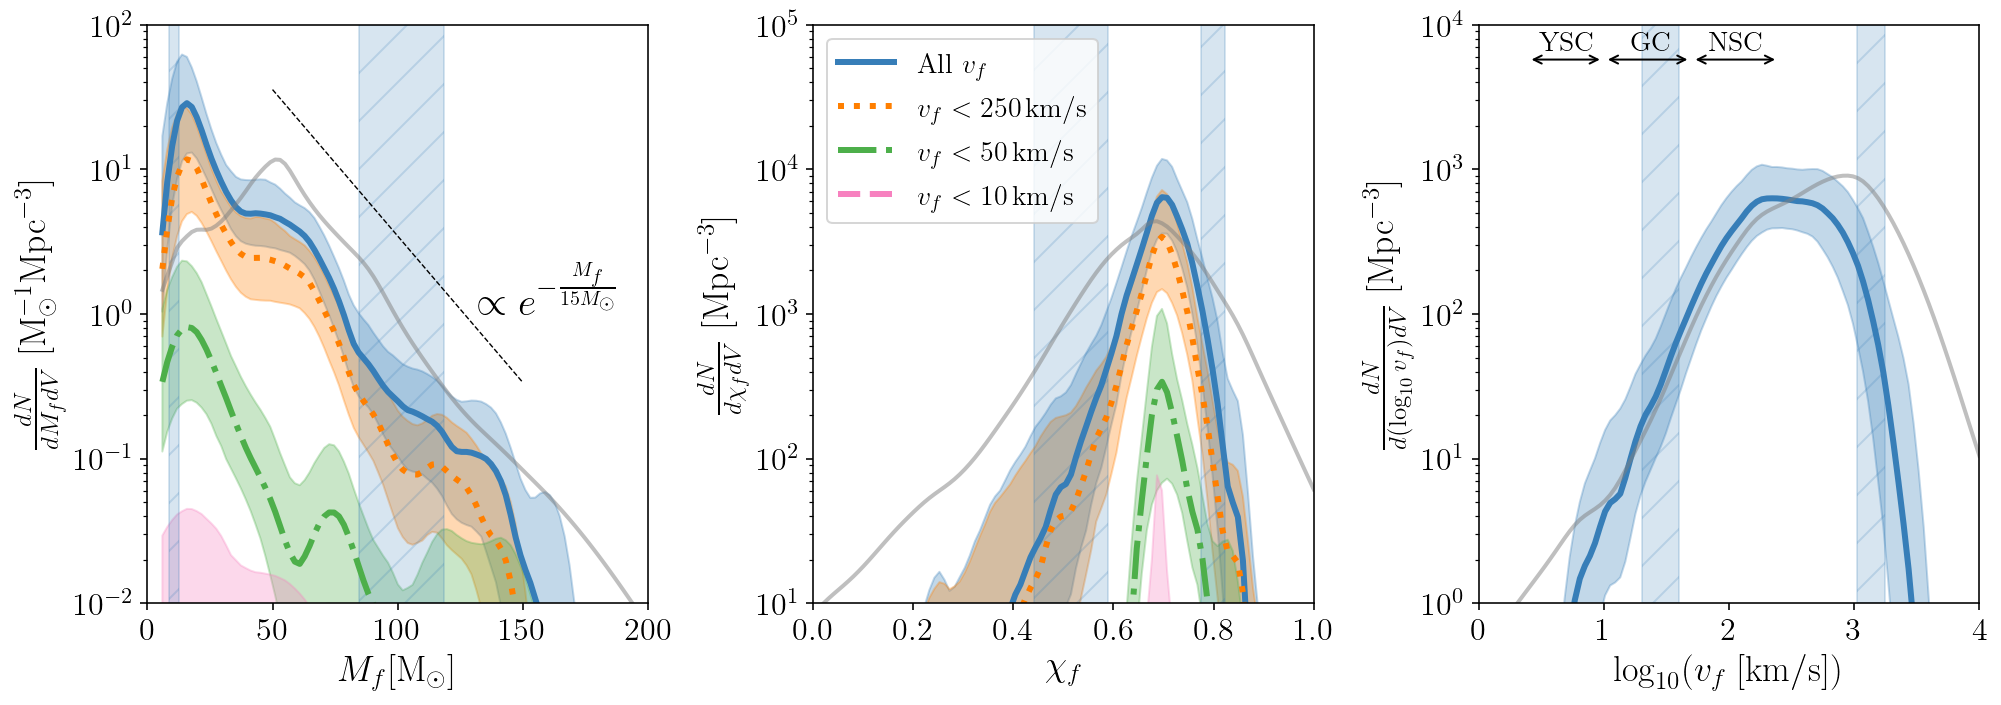

In [78]:
units = ['[\mathrm{{M}}_{{\odot}}]','','\;[\mathrm{km/s}]']
yunits = ['\;[\mathrm{{M}}_\odot^{{-1}}\mathrm{{Mpc}}^{{-3}}]','\;[\mathrm{{Mpc}}^{{-3}}]','\;[\mathrm{{Mpc}}^{{-3}}]']
logunits = [False,False,True]
xlims = [(0,200),(0,1),(0,4)]
ylims = [(1e-2,1e2),(1e1,1e5),(1e0,1e4)]
xlabels = ['M_f','\chi_f','v_f']
cluster_colors = ['tab:purple','tab:orange','tab:green']
cluster_labels = [r'$v_f<10\,\mathrm{km/s}$',r'$v_f<50\,\mathrm{km/s}$',r'$v_f<250\,\mathrm{km/s}$']
cluster_ls = ['--','-.',':']
cluster_colors = ['#f781bf','#4daf4a', '#ff7f00']
prior_scales = [5e2,1e3,1e3]

fig,ax = plt.subplots(1,3,figsize=(14,5))
for j in range(len(ax)):
    ax[j].tick_params(labelsize=16)
    paramlines = lines[:,:,j]
        
    # plot the individual population lines
    #for i in range(lines.shape[1]):
    #    ax[j].plot(plot_grids[j],paramlines[:,i],color='k',alpha=0.5,zorder=0,lw=0.1)
    
    # plot the credible region and median
    ax[j].fill_between(plot_grids[j],np.percentile(paramlines,5,axis=1),np.percentile(paramlines,95,axis=1),color='#377eb8',alpha=0.3)
    ax[j].plot(plot_grids[j],np.median(paramlines,axis=1),color='#377eb8',lw=3,label=r'$\textrm{All}\, \, v_f$')
    ax[j].set_ylim(ylims[j])
    ax[j].set_xlim(xlims[j])
    ax[j].set_yscale('log')
    
    # plot the prior ppds 
    ax[j].plot(plot_grids[j],prior_scales[j]*np.mean(prior_lines[:,:,j],axis=1),color='gray',lw=2,alpha=0.5)
    
    # plot the medians conditioned on the cluster escape velocities
    if j < 2:
        for si in range(vf_cluster_lines.shape[3])[::-1]:
            ax[j].plot(plot_grids[j],np.median(vf_cluster_lines[:,:,j,si],axis=1),color=cluster_colors[si],linestyle=cluster_ls[si],lw=3,label=cluster_labels[si])
            ax[j].fill_between(plot_grids[j],np.percentile(vf_cluster_lines[:,:,j,si],5,axis=1),np.percentile(vf_cluster_lines[:,:,j,si],95,axis=1),color=cluster_colors[si],alpha=0.3)

    # If using a pre-logged variable
    if logunits[j]:
        ax[j].set_xlabel(r'$\log_{{10}}({}{})$'.format(xlabels[j],units[j]),fontsize=18)
        ax[j].set_ylabel(r'$\frac{{dN}}{{d(\log_{{10}}{})dV}}{}$'.format(xlabels[j],yunits[j]),fontsize=18)
    else:
        ax[j].set_xlabel(f'${xlabels[j]}{units[j]}$',fontsize=18)
        ax[j].set_ylabel(r'$\frac{{dN}}{{d{}dV}}{}$'.format(xlabels[j],yunits[j]),fontsize=18)
                           
    # plot the percentile credible regions
    trans = mtransforms.blended_transform_factory(ax[j].transData, ax[j].transAxes)
    for k in [0,2]:
        ax[j].fill_between(
            np.array([np.percentile(pctl_array[k,:,j],10),np.percentile(pctl_array[k,:,j],90)]),
            0,1,
            facecolor='#377eb8',alpha=0.2,transform=trans,hatch='/',edgecolor='#377eb8')


# draw the approximate exponential fitting the final mass distribution
x1,y1 = [10,20] #two points eyeballed to get approximate exponential
x2,y2 = [150,0.01]
#mexp = round(-(x1-x2)/np.log(y1/y2))
mexp = 15
ax[0].plot(np.linspace(50,150,20),1000.*np.exp(-np.linspace(50,120,20)/mexp),ls='--',color='black',lw=0.7)
ax[0].annotate(r'$\propto e^{-\frac{M_f}{'+str(mexp)+r'M_\odot}}$',xy=(0.66,0.5),xycoords='axes fraction',fontsize=20)
        
ax[1].legend(loc=2,fontsize=14)

# add cluster escape velocity ranges
ax[2].annotate("", xy=(0.25, 0.94), xytext=(0.39/4, 0.94), arrowprops=dict(arrowstyle="<->"),xycoords='axes fraction')
ax[2].annotate(r"$\mathrm{YSC}$", xy=(0.12, 0.955),xycoords='axes fraction',fontsize=14)

ax[2].annotate("", xy=(1.7/4, 0.94), xytext=(0.25, 0.94), arrowprops=dict(arrowstyle="<->"),xycoords='axes fraction')
ax[2].annotate(r"$\mathrm{GC}$", xy=(0.305, 0.955),xycoords='axes fraction',fontsize=14)

ax[2].annotate("", xy=(2.4/4, 0.94), xytext=(1.7/4, 0.94), arrowprops=dict(arrowstyle="<->"),xycoords='axes fraction')
ax[2].annotate(r"$\mathrm{NSC}$", xy=(0.46, 0.955),xycoords='axes fraction',fontsize=14)


fig.tight_layout()
fig.savefig('final_param_dist.pdf')
fig.savefig('final_param_dist.png',dpi=300)

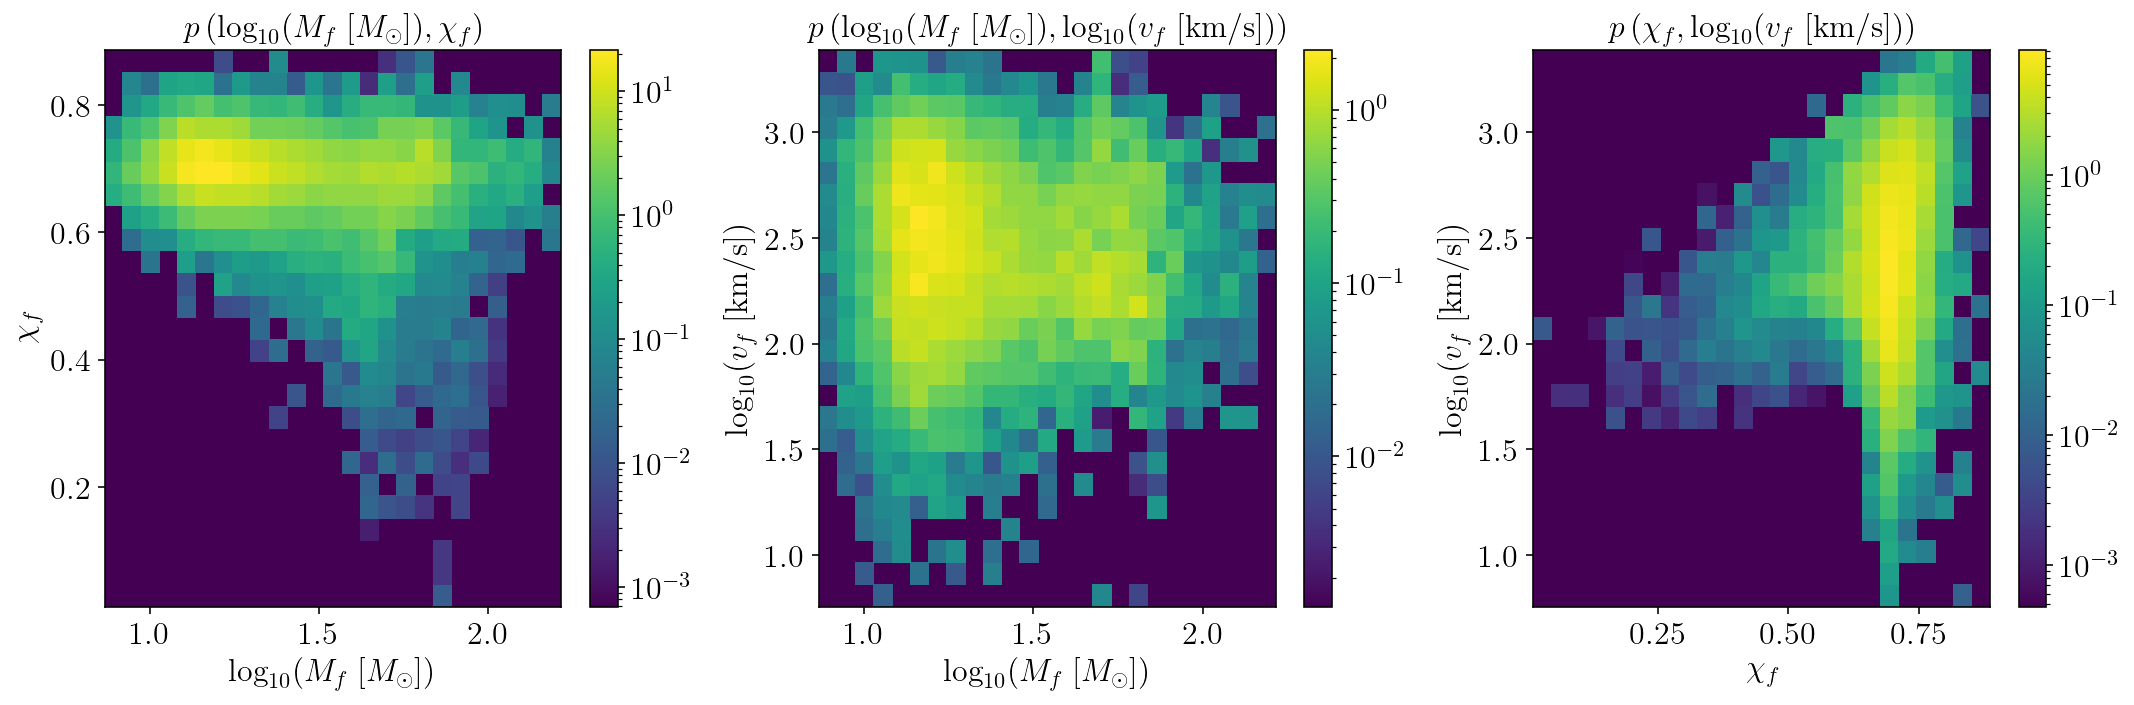

In [79]:
new_wts_arr = np.empty(n_hyper_lines*n_event_samples)
new_fin_params_arr = np.empty((n_hyper_lines*n_event_samples,final_params.shape[1]))
for i in range(n_hyper_lines):
    new_wts_arr[(i*n_event_samples):((i+1)*(n_event_samples))] = wts_arr[i,:]
    new_fin_params_arr[i*n_event_samples:(i+1)*(n_event_samples),:] = final_params

transforms = [lambda x:np.log10(x), lambda x:x, lambda x:(np.log10(3e5*x))]
labels = [r'\log_{10}(M_f\; [M_{\odot}])',r'\chi_f',r'\log_{10}(v_f\; [\mathrm{km/s}])']
names = ['Mf','xf','vf']
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax = ax.flatten()
ax_num=0
for j in range(n_params):
    for k in range(n_params):
        if k <= j:
            continue    
        #fig,ax = plt.subplots()
        my_cmap = plt.cm.viridis
        ax[ax_num].set_facecolor(my_cmap(0))
        im = ax[ax_num].hist2d(transforms[j](new_fin_params_arr[:,j]),transforms[k](new_fin_params_arr[:,k]),
                   weights=new_wts_arr,density=True,bins=25,norm=matplotlib.colors.LogNorm(),cmap=my_cmap)
        ax[ax_num].set_xlabel(r'$'+labels[j]+r'$',fontsize=16)
        ax[ax_num].set_ylabel(r'$'+labels[k]+r'$',fontsize=16)
        ax[ax_num].set_title(r'$p\left('+labels[j]+','+labels[k]+r'\right)$',fontsize=16)
        ax[ax_num].tick_params(labelsize=16)
        cb = fig.colorbar(im[3], ax=ax[ax_num])
        cb.ax.tick_params(labelsize=16)
        ax_num += 1
fig.tight_layout()
fig.savefig(f'remnant_2d_dist.pdf')
fig.savefig(f'remnant_2d_dist.png',dpi=300)